In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import copy
import seaborn as sns
import tensorflow as tf

from sklearn.linear_model import LinearRegression

In [466]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU detected:")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPU detected. The code will run on the CPU.")

GPU detected:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [467]:
cols=['bike_count','hour','temp','humidity','wind','visibility','dew_pt_temp','radiation','rain','snow','funcDay']

In [468]:
df=pd.read_csv('SeoulBikeData.csv',encoding='ISO-8859-1').drop(['Date','Holiday','Seasons'],axis=1)
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [469]:
df.columns=cols

In [470]:
df['funcDay']=(df["funcDay"]=='Yes').astype(int)
df=df[df['hour']==12]
df=df.drop(['hour'],axis=1)

In [471]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Display columns with missing values
print("Missing values in each column:")
print(missing_values[missing_values > 0])


Missing values in each column:
Series([], dtype: int64)


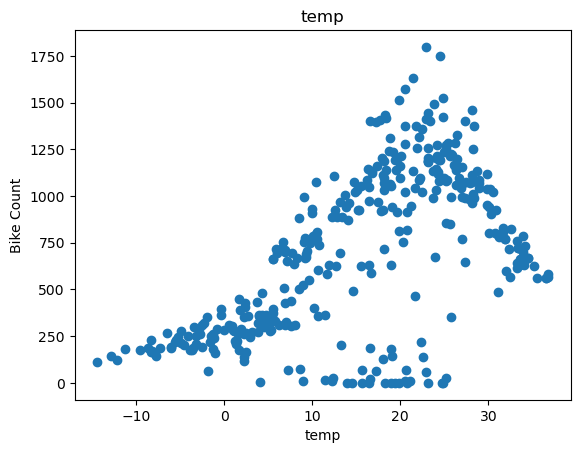

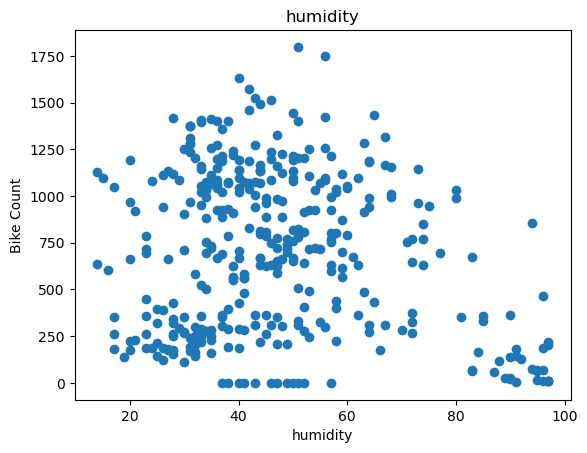

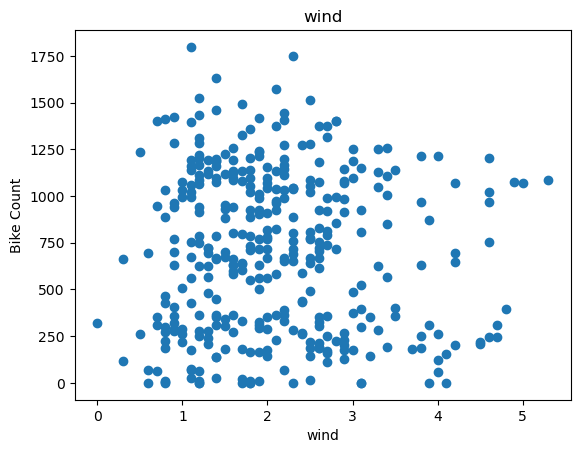

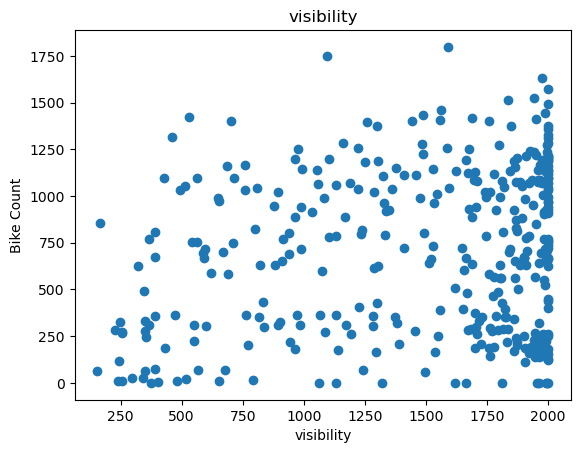

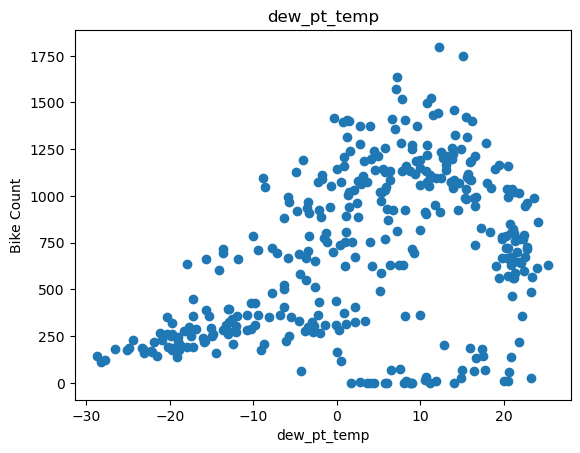

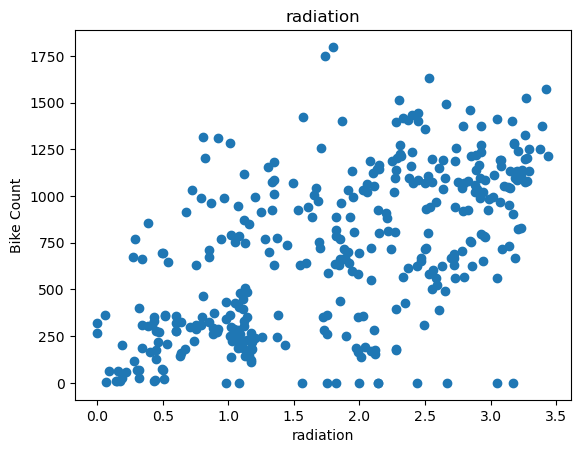

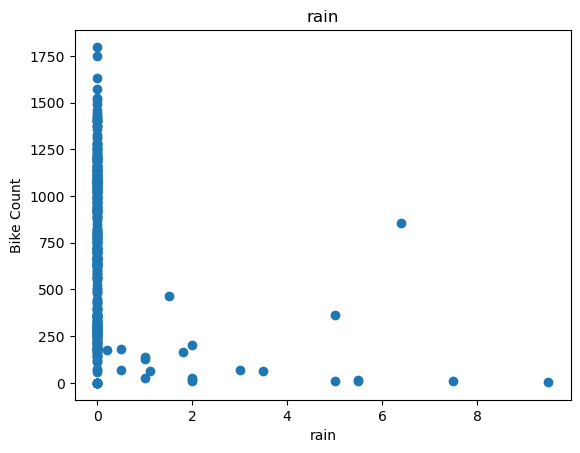

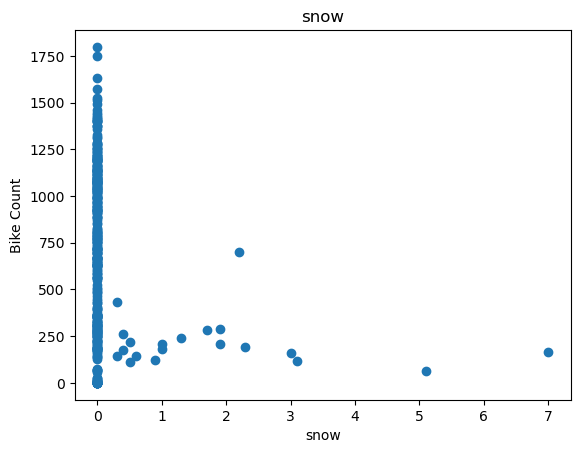

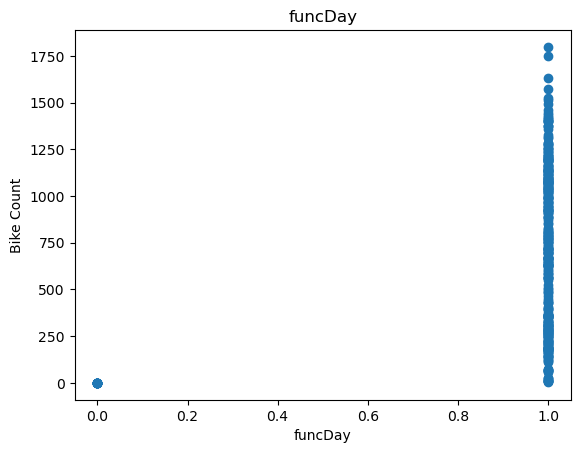

In [472]:
for label in df.columns[1:]:
    
    plt.scatter(df[label], df['bike_count'])  # Only plot rows without NaN
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('Bike Count')
    plt.show()


In [473]:
#dropping the ones which are non-linear
df=df.drop(['wind','visibility','funcDay'],axis=1)

In [474]:
#split-x-y
x=df['bike_count']
y=df.drop(['bike_count'],axis=1)
y

,temp,humidity,dew_pt_temp,radiation,rain,snow
12,1.7,23,-17.2,1.11,0.0,0.0
36,4.3,41,-7.8,1.09,0.0,0.0
60,5.8,85,3.4,0.43,0.0,0.0
84,-0.3,38,-12.9,1.11,0.0,0.0
108,-2.3,25,-19.7,0.00,0.0,0.0
...,...,...,...,...,...,...
8652,9.1,57,1.0,1.69,0.0,0.0
8676,9.3,61,2.1,0.85,0.0,0.0
8700,7.9,14,-18.0,1.81,0.0,0.0
8724,5.6,27,-11.9,0.34,0.0,0.0


In [475]:
#train-test-val-split
def split_data(df, test_size=0.2, val_size=0.1, random_state=None):

    # First, split the data into train and test sets
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Adjust the validation size based on the remaining training data
    adjusted_val_size = val_size / (1 - test_size)
    
    # Now, split the train set into train and validation sets
    train_df, val_df = train_test_split(train_df, test_size=adjusted_val_size, random_state=random_state)
    
    return train_df, val_df, test_df

In [476]:
train,val,test=split_data(df)

In [477]:
def get_xy(df,y_label,x_labels=None,):
    dataframe=copy.deepcopy(df)
    if x_labels is None:
        x=dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels)==1:
            x=dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            x=dataframe[x_labels].values
    y=dataframe[y_label].values.reshape(-1,1)
    data=np.hstack((x,y))
    return data,x,y

In [478]:
_,x_train_temp,y_train_temp=get_xy(train,'bike_count',x_labels=['temp'])
_,x_val_temp,y_val_temp=get_xy(val,'bike_count',x_labels=['temp'])
_,x_test_temp,y_test_temp=get_xy(test,'bike_count',x_labels=['temp'])


### Simple Linear regression

In [479]:
temp_reg=LinearRegression()
temp_reg.fit(x_train_temp,y_train_temp)

LinearRegression()

In [480]:
print(temp_reg.coef_,temp_reg.intercept_)

[[20.02424883]] [391.71262749]


In [481]:
temp_reg.score(x_test_temp,y_test_temp)

0.3325203916373569

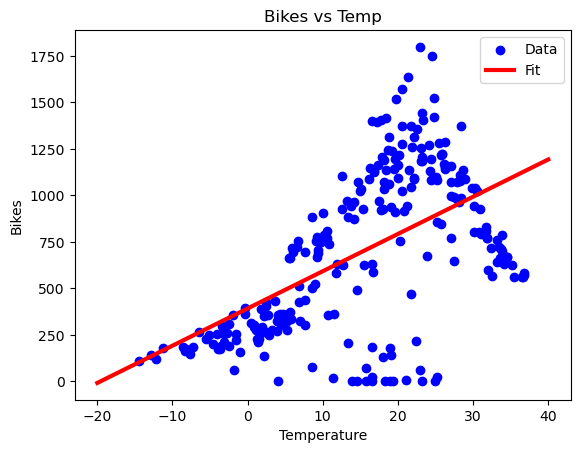

In [482]:
plt.scatter(x_train_temp,y_train_temp,label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_reg.predict(np.array(x).reshape(-1,1)),label="Fit",color='red',linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Bikes')
plt.xlabel('Temperature')
plt.show()

### Multiple Linear Reg

In [483]:
_,x_train_all,y_train_all=get_xy(train,'bike_count',x_labels=df.columns[1:])
_,x_val_all,y_val_all=get_xy(val,'bike_count',x_labels=df.columns[1:])
_,x_test_all,y_test_all=get_xy(test,'bike_count',x_labels=df.columns[1:])


In [484]:
all_reg=LinearRegression()
all_reg.fit(x_train_all,y_train_all)

LinearRegression()

In [485]:
all_reg.score(x_test_all,y_test_all)

0.5698534193618012

In [486]:
y_pred_lr=all_reg.predict(x_test_all)

### Regression with NN

In [487]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [488]:
temp_nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [489]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [490]:
history=temp_nn_model.fit(
    x_train_temp.reshape(-1,),y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_temp,y_val_temp)
)

In [491]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

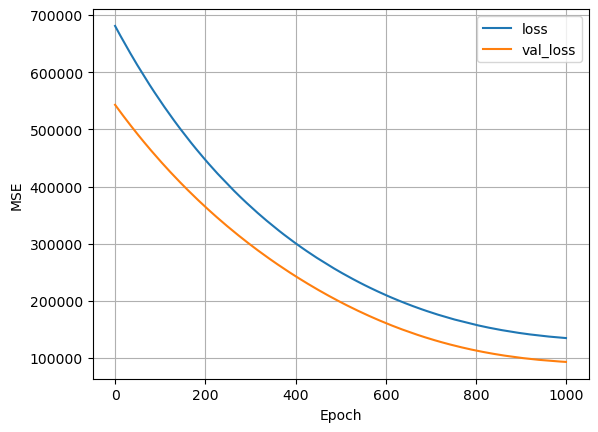

In [492]:
plot_loss(history)

4/4 [==============================] - 0s 1ms/step


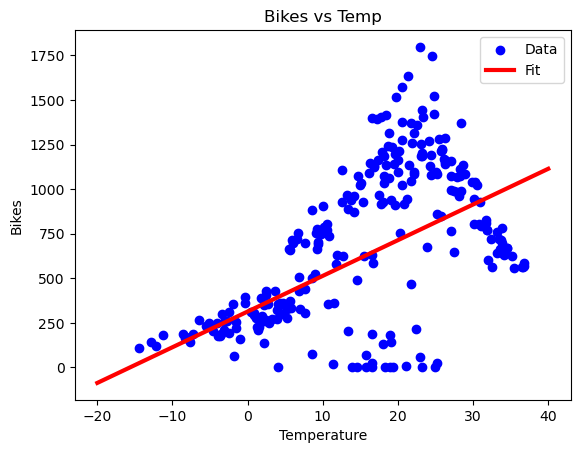

In [493]:
plt.scatter(x_train_temp,y_train_temp,label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color='red',linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Bikes')
plt.xlabel('Temperature')
plt.show()

### All features NN

In [543]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,),axis=-1)
all_normalizer.adapt(x_train_all)

In [564]:
all_nn_model=tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(64),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32),
    # tf.keras.layers.Dense(32, activation='relu'),

    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [565]:
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [566]:
x_train_all.shape

(255, 6)

In [567]:
history=all_nn_model.fit(
    x_train_all,y_train_all,
    epochs=100,
    verbose=0,
    validation_data=(x_val_all,y_val_all)
)

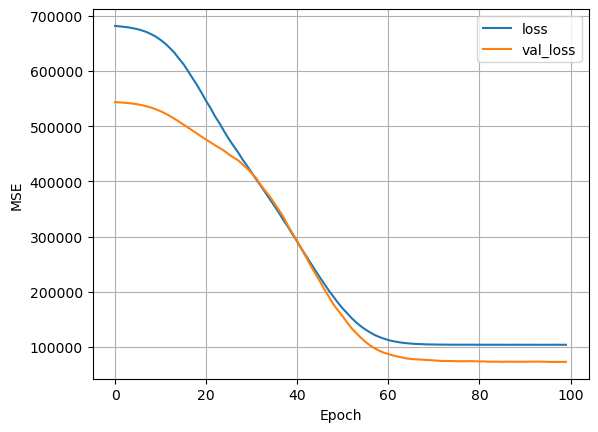

In [568]:
plot_loss(history)

In [569]:
#calculate MSE- lin reg and nn

y_pred_nn=all_nn_model.predict(x_test_all)

3/3 [==============================] - 0s 2ms/step


In [570]:
def MSE(y_pred,y_real):
    return (np.square(y_pred-y_real)).mean()

In [571]:
MSE(y_pred_lr,y_test_all)

80008.60165851626

In [572]:
MSE(y_pred_nn,y_test_all)

80348.01715563347

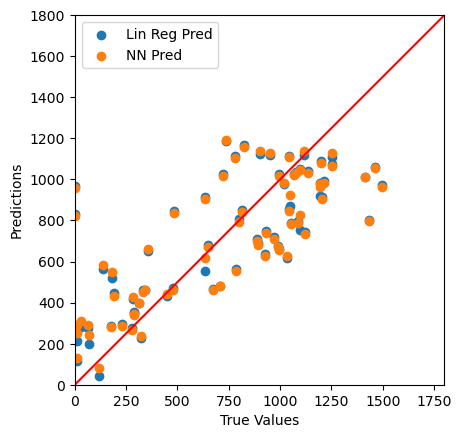

In [573]:
ax=plt.axes(aspect='equal')
plt.scatter(y_test_all,y_pred_lr,label='Lin Reg Pred')
plt.scatter(y_test_all,y_pred_nn,label='NN Pred')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims=[0,1800]
plt.ylim(lims)
plt.xlim(lims)
plt.legend()
plt.plot(lims,lims,c='red')